<a href="https://colab.research.google.com/github/hikaru677/Frame-interpolation-dataset-creation/blob/main/apply_mask_to_frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation function

## Import and Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import random
import os
import ssl
import cv2
import numpy as np
import imageio
from IPython import display
from urllib import request
import re
import tempfile
import math
from tqdm.notebook import tqdm

Mounted at /content/drive


In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 158.1 MB/s eta 0:00:01tcmalloc: large alloc 2041339904 bytes == 0x33cc000 @  0x7f64491bc680 0x7f64491dd824 0x5b3128 0x5bbc90 0x5f714c 0x64d800 0x527022 0x504866 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x5f5ee6 0x56bbe1

In [ ]:
! pip install SSIM-PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

1.9.0+cu111 True


/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


2.27.0
11.1
GCC 7.3
--2023-01-22 12:58:26--  https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.82.216, 163.181.82.219, 163.181.82.212, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.82.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M   218MB/s    in 0.8s    

2023-01-22 12:58:27 (218 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



In [ ]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


MaskRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

### Install for Segmentation

In [ ]:
! pip install cython
! git clone https://github.com/cocodataset/cocoapi.git
! cd cocoapi/PythonAPI/
! make install
! python setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (576/576), done.
make: *** No rule to make target 'install'.  Stop.
running install
running bdist_egg
running egg_info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mmdet
copying mmdet/__init__.py -> build/lib/mmdet
copying mmdet/version.py -> build/lib/mm

## function to get Frame and video path

In [ ]:
# fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
unverified_context = ssl._create_unverified_context()
UCF_DATA_FOLDER = "/content/drive/MyDrive/UCF101_Unzipped_Files/UCF-101"

def list_ucf_videos():
    global _VIDEO_LIST
    if not _VIDEO_LIST:
        index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
        videos = re.findall("(v_[\w_]+\.avi)", index)
        _VIDEO_LIST = sorted(set(videos))
    return list(_VIDEO_LIST)

def fetch_ucf_video(video):
    action_dir = video.split('_')[1]
    if action_dir == "HandstandPushups":
      action_dir = "HandStandPushups"
      text_list = video.split('_')
      base_video_path = text_list[0]+ '_' + action_dir + '_' + text_list[2] + '_' + text_list[3]
      video_path = os.path.join(UCF_DATA_FOLDER,action_dir,base_video_path)
      print(video_path)
      return video_path

    video_path = os.path.join(UCF_DATA_FOLDER,action_dir,video)
    return video_path

def path_modify(video):
  action_dir = video.split('_')[1]
  if action_dir == "HandstandPushups":
      action_dir = "HandStandPushups"
      text_list = video.split('_')
      base_video_path = text_list[0]+ '_' + action_dir + '_' + text_list[2] + '_' + text_list[3]
      print(base_video_path)
      return base_video_path

  return video


In [ ]:
#function to capture first and last frames
def capture_first_last_frames(videofile):

    vidcap = cv2.VideoCapture(videofile)
    totalframecount = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    #print("このビデオの合計フレーム数は：" , totalframecount)
    frameIndex = totalframecount-1
    count = 0

    file_name  = os.path.basename(os.path.splitext(videofile)[0])#v_VolleyballSpiking_g01_c01という文字を取り出す
    action_name = file_name.split("_")[1]
    gather_file="/content/drive/MyDrive/UCF101_first_last_frame/"+ action_name + "/frames_"+ file_name

    #if

    if not os.path.isdir(gather_file):
        os.makedirs(gather_file)#v_VolleyballSpiking_g01_c01のフレームを格納するdirectoryを作成

    if not os.path.isfile("/content/drive/MyDrive/UCF101_first_last_frame/"+ action_name + "/frames_%s/%s.png" % (file_name,str(count).zfill(6))):
        ret, image = vidcap.read()
        cv2.imwrite("/content/drive/MyDrive/UCF101_first_last_frame/"+ action_name + "/frames_%s/%s.png" % (file_name,str(count).zfill(6)), image)
        # save frame as png file
        success,image = vidcap.read()
        # print('Read a new frame: ', success)
    count += 1

    if not os.path.isfile("/content/drive/MyDrive/UCF101_first_last_frame/"+ action_name + "/frames_%s/%s.png" % (file_name,str(count).zfill(6))):
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frameIndex)
        ret, image = vidcap.read()

        if ret == False:
            while True:
                frameIndex -= 1
                vidcap.set(cv2.CAP_PROP_POS_FRAMES, frameIndex)
                ret, image = vidcap.read()
                if ret == True:
                    break

        cv2.imwrite("/content/drive/MyDrive/UCF101_first_last_frame/"+ action_name + "/frames_%s/%s.png" % (file_name,str(count).zfill(6)), image)
        # save frame as png file
        success,image = vidcap.read()
        # print('/Read a new frame: ', success)

    return vidcap.get(cv2.CAP_PROP_FPS),gather_file

In [ ]:
# Get video.
def video_folder_capture(base_path):
  video_path = fetch_ucf_video(base_path)
  fps,gathered_folder = capture_first_last_frames(video_path)
  return gathered_folder,video_path

## Segmentation

In [ ]:
from mmdet.core import encode_mask_results

#function to get variables
def define_variable(gathered_folder):
  first_frame = gathered_folder + "/000000.png"
  second_frame = gathered_folder + "/000001.png"
  result_1 = inference_detector(model, first_frame)
  result_2 = inference_detector(model, second_frame)
  bbox_1, segm_1 = result_1
  bbox_2, segm_2 = result_2
  first_frame_im = cv2.imread(first_frame)
  second_frame_im = cv2.imread(second_frame)

  return first_frame, second_frame, result_1, result_2, bbox_1, segm_1, bbox_2, segm_2, first_frame_im, second_frame_im

### Helper functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pycocotools.mask as mask

#function to apply mask
def mask_output(seg,bbox,original_im,thr=0.2):#maskの閾値
  masking_img = np.ones_like(original_im)
  masking_img = masking_img[:,:,0]
  masking_img = masking_img[:,:,np.newaxis]
  #print(masking_img.shape)
  seg_con = mmcv.concat_list(seg)

  if seg_con == []:#maskが一つもないなら全要素が１のマスクを出力
    return masking_img,seg_con

  enc_seg = encode_mask_results([seg_con])#encode
  mask_list=mask.decode(enc_seg[0])#decode 01
  bboxes = np.vstack(bbox)
  box_confidence = bboxes[:,-1]
  bool_ = len(box_confidence) == len(seg_con)

  count = 0
  for i in range(len(seg_con)):#len(seg_con)はマスクの枚数
    if box_confidence[i] > thr:
      maskedArr = mask_list[:,:,i]
      img = maskedArr
      img = img[:,:,np.newaxis]
      img = -img + 1 #reverse 01
      if count == 0:
        masking_img = img
        # concat_img = np.concatenate([img,img,img],axis=2)
        # print(concat_img.shape)
      masking_img = np.multiply(masking_img,img)#broadcast automatically
      count += 1
  #mask_number = count
  return masking_img,mask_list

In [ ]:
#function to apply two mask
def double_masking_img(first_frame_im,second_frame_im,mask_1,mask_2):
  masking_first_frame = np.multiply(np.multiply(first_frame_im,mask_1),mask_2)
  masking_second_frame = np.multiply(np.multiply(second_frame_im,mask_1),mask_2)
  return masking_first_frame,masking_second_frame

In [ ]:
#function to output two images side by side
def output_2img(img_1,img_2,video_path = " ",mask_bool=False):
  if mask_bool==True:
    adjust = 255
  else:
    adjust = 1

  img_1 = img_1.astype(np.uint8)
  img_2 = img_2.astype(np.uint8)

  part_video_path = video_path.split('/')[-1]
  mask_image_1 = cv2.cvtColor(img_1*adjust, cv2.COLOR_BGR2RGB)
  mask_image_2 = cv2.cvtColor(img_2*adjust, cv2.COLOR_BGR2RGB)
  fig = plt.figure(figsize = (12,4))
  ax = fig.add_subplot(1,2,1)
  ax.imshow(mask_image_1)
  ax.set_title(part_video_path)
  ax.axis("off")
  ax = fig.add_subplot(1,2,2)
  ax.imshow(mask_image_2)
  ax.axis("off")

In [ ]:
def synthesize_2mask(mask1,mask2):
  mask_ = np.multiply(mask_2,mask_1)
  return mask_

In [ ]:
#function to calculate PSNR for some regions of the image
def portion_calculate_PSNR(img1,img2):
    rss = np.sum((img1.astype(float) - img2.astype(float)) ** 2)#元がuintなので型変換
    divisor = np.count_nonzero(img1!=0)
    if rss == 0:
        return 100
    mse = rss/divisor
    PIXEL_MAX = 255.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

    # print("zero is",np.count_nonzero((img1.astype(float) - img2.astype(float))==0))
    # print(np.count_nonzero(img1==0))#マスクされた画像の部分が0であることを示している
    # print(divisor)#元のマスクされた画像においてマスクされている部分以外の0以外の要素の数をカウント
    return PSNR

In [ ]:
#function to calculate normal PSNR
def psnr_a(img_1, img_2, data_range=255):
    mse = np.mean((img_1.astype(float) - img_2.astype(float)) ** 2)
    print(mse)
    return 10 * np.log10((data_range ** 2) / mse)


In [ ]:
def calc_SSIM(image_0,image_1,mask_01):
    image_0 = image_0.astype(float)
    image_1 = image_1.astype(float)
    tile_size = 11 #tile sizeをいくつにするか
    pixel_len = 0
    width = image_0.shape[0]
    height = image_0.shape[1]
    width = width // tile_size * tile_size #tile_sizeで割り切れる数に設定しなおす
    height = height // tile_size * tile_size
    dynamic_range = 255
    c_1 = (dynamic_range * 0.01) ** 2
    c_2 = (dynamic_range * 0.03) ** 2
    channels = range(image_0.shape[2])
    ssim = 0.0
    MSSIM = 0.0
    win_count = 0

    for x in range(0, width, tile_size):
        for y in range(0, height, tile_size):

            # Get pixel tile
            #box = (x, y, x + tile_size, y + tile_size)
            tile_0 = image_0[x:x+tile_size,y:y+tile_size,:]#image_0からタイルを取り出す(1)
            tile_1 = image_1[x:x+tile_size,y:y+tile_size,:]#image_1からタイルを取り出す(2)
            tile_mask_01 = mask_01[x:x+tile_size,y:y+tile_size,0]#mask01からタイルを取り出す(3)
            pixel_len = np.count_nonzero(tile_mask_01 != 0)#maskのタイルから0以外の要素をカウント(4)


            if pixel_len != 0:

                for i in channels:
                    pixel0, pixel1 = tile_0[:,:,i], tile_1[:,:,i]#imageのタイルは3チャネルあるので、そのうち1つを取り出す(5)

                    covariance = 0.0

                    pixel_sum_0 = np.sum(pixel0[tile_mask_01 != 0])#tile_0から取り出したチャネルのうち0以外の要素を合計する(8)(o)
                    pixel_sum_1 = np.sum(pixel1[tile_mask_01 != 0])#tile_1から取り出したチャネルのうち0以外の要素を合計する(9)(o)

                    average_0 = pixel_sum_0 / pixel_len#(o)
                    average_1 = pixel_sum_1 / pixel_len#(o)

                    covariance = np.sum((pixel0[tile_mask_01 != 0] - average_0)*(pixel1[tile_mask_01 != 0] - average_1)) / pixel_len#(o)
                    #ccc = np.cov(pixel0.reshape(-1), pixel1.reshape(-1))

                    # Calculate the sum of both image's variances
                    variance_0 = np.var(pixel0[tile_mask_01 != 0])#(o)
                    variance_1 = np.var(pixel1[tile_mask_01 != 0])
                    variance_0_1 = variance_0+variance_1

                    ssim = (2.0 * average_0 * average_1 + c_1) * (2.0 * covariance + c_2) / (average_0 * average_0 + average_1 * average_1 + c_1) / (variance_0_1 + c_2)
                    MSSIM += ssim

                    win_count += 1
            else:
                MSSIM += 0.0

    MSSIM = MSSIM / win_count
    return MSSIM,win_count

In [ ]:
def SSIM_com(image_0, image_1, mask_01 = np.ones((240,320,1))):
    # Verify input parameters
    if image_0.shape != image_1.shape:
        raise AttributeError('The images do not have the same resolution')

    #print(calc_SSIM(image_0,image_1,mask_01))
    return calc_SSIM(image_0,image_1,mask_01)

In [ ]:
def fetch_action_list(action = "BandMarching"):
    list_data = list_ucf_videos()
    return [i for i in list_data if i.split('_')[1] == action]


def fetch_from_middle(action = "SoccerPenalty"):
    cache_action_list = []
    run_action_list = []
    list_data = list_ucf_videos()

    for base_path in list_data:
        cache_action_list.append(base_path.split('_')[1])
        if action in set(cache_action_list):
            run_action_list.append(base_path)

    return run_action_list



In [ ]:
import shutil
def classify_file_with_PSNR_SSIM(fetch_path,judge_PSNR,judge_SSIM):
  PSNR_thr = 11.5
  SSIM_thr = 0.5
  action_dir = fetch_path.split('_')[1]


  requirement_path = os.path.join("/content/drive/MyDrive/Classified_UCF101/Fixed_Camera", action_dir, fetch_path)
  no_requirement_path = os.path.join("/content/drive/MyDrive/Classified_UCF101/Unfixed_Camera", action_dir, fetch_path)
  original_path = os.path.join("/content/drive/MyDrive/UCF101_Unzipped_Files/UCF-101", action_dir, fetch_path)
  Fixed_class_dir =os.path.join("/content/drive/MyDrive/Classified_UCF101/Fixed_Camera", action_dir)
  Unfixed_class_dir = os.path.join("/content/drive/MyDrive/Classified_UCF101/Unfixed_Camera", action_dir)


  if (judge_PSNR > PSNR_thr) and (judge_SSIM > SSIM_thr):
    if not os.path.isdir(Fixed_class_dir):
      os.mkdir(Fixed_class_dir)
    if not os.path.exists(requirement_path): #コピーする先のファイルにvideoがあるかどうか確認
      shutil.copy(os.path.join("/content/drive/MyDrive/UCF101_Unzipped_Files/UCF-101", action_dir, fetch_path),os.path.join("/content/drive/MyDrive/Classified_UCF101/Fixed_Camera", action_dir))
      #shutil.move(os.path.join("/content/drive/MyDrive/UCF101_Unzipped_Files/UCF-101", action_dir, fetch_path),os.path.join("/content/drive/MyDrive/Classified_UCF101/Fixed_Camera", action_dir))

  else:
    if not os.path.isdir(Unfixed_class_dir):
      os.mkdir(Unfixed_class_dir)
    if not os.path.exists(no_requirement_path): #コピーする先のファイルにvideoがあるかどうか確認
      shutil.copy(os.path.join("/content/drive/MyDrive/UCF101_Unzipped_Files/UCF-101", action_dir, fetch_path),os.path.join("/content/drive/MyDrive/Classified_UCF101/Unfixed_Camera", action_dir))
      #shutil.move(os.path.join("/content/drive/MyDrive/UCF101_Unzipped_Files/UCF-101", action_dir, fetch_path),os.path.join("/content/drive/MyDrive/Classified_UCF101/Fixed_Camera", action_dir))
  return

In [ ]:
def select_bbox_segm(bbox_1,segm_1,bbox_2,segm_2):
  new_bbox_1 = []
  new_segm_1 = []
  new_bbox_2 = []
  new_segm_2 = []
  index_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 67, 73, 75, 76, 77, 78, 79]
  for i in index_list:
    new_bbox_1.append(bbox_1[i])
    new_segm_1.append(segm_1[i])
    new_bbox_2.append(bbox_2[i])
    new_segm_2.append(segm_2[i])
  return new_bbox_1,new_segm_1,new_bbox_2,new_segm_2

### output_reslut

In [ ]:
def run_functions_output_results(fetch_path,plt_bool=False):
  gathered_folder,video_path = video_folder_capture(fetch_path)
  first_frame, second_frame, result_1, result_2, bbox_1, segm_1, bbox_2, segm_2, first_frame_im, second_frame_im = define_variable(gathered_folder)

  bbox_1,segm_1,bbox_2,segm_2 = select_bbox_segm(bbox_1,segm_1,bbox_2,segm_2)##

  mask_1,mask_list_1 = mask_output(segm_1,bbox_1,first_frame_im) #元画像のshapeも渡すようにする
  mask_2,mask_list_2 = mask_output(segm_2,bbox_2,second_frame_im)

  masking_first_frame_12,masking_second_frame_12 = double_masking_img(first_frame_im,second_frame_im,mask_1,mask_2)

  if plt_bool==True:
    output_2img(masking_first_frame_12,masking_second_frame_12,video_path)

  return masking_first_frame_12,masking_second_frame_12, first_frame_im,second_frame_im,mask_1,mask_2

In [ ]:
fetch_list = fetch_action_list("YoYo") #WritingOnBoard#YoYo
#fetch_list = list_ucf_videos()
for fetch_path in tqdm(fetch_list):
  masking_first_frame_12,masking_second_frame_12,first_frame_im,second_frame_im,mask_1,mask_2 = run_functions_output_results(fetch_path) #,True)
  mask_ = synthesize_2mask(mask_1,mask_2)
  psnr_each = portion_calculate_PSNR(masking_first_frame_12,masking_second_frame_12)
  ssim,window_num = SSIM_com(first_frame_im,second_frame_im,mask_)

  fetch_path = path_modify(fetch_path)

  classify_file_with_PSNR_SSIM(fetch_path,psnr_each,ssim) #classify video

  #print(fetch_path + " PSNR :",psnr_each,end = '\n')
  #print(fetch_path + " SSIM :",ssim,end = '\n')

  0%|          | 0/128 [00:00<?, ?it/s]

/content/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#### 表示確認

In [ ]:
#v_BandMarching_g02_c03
gathered_folder,video_path = video_folder_capture("v_Biking_g09_c03.avi")
#例外:v_WalkingWithDog_g13_c03,v_WalkingWithDog_g23_c03#v_CricketBowling_g12_c06#v_TennisSwing_g15_c01#v_Biking_g09_c03.avi#v_CricketBowling_g12_c06.avi

In [ ]:
first_frame, second_frame, result_1, result_2, bbox_1, segm_1, bbox_2, segm_2, first_frame_im, second_frame_im = define_variable(gathered_folder)

In [ ]:
bbox_1,segm_1,bbox_2,segm_2 = select_bbox_segm(bbox_1,segm_1,bbox_2,segm_2)

In [ ]:
bboxes = np.vstack(bbox_1)
box_confidence = bboxes[:,-1]

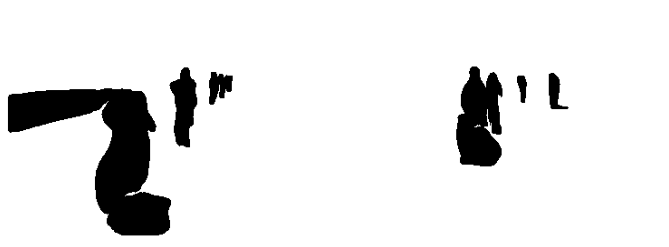

In [ ]:
mask_1,mask_list_1 = mask_output(segm_1,bbox_1,first_frame_im)
mask_2,mask_list_2 = mask_output(segm_2,bbox_2,second_frame_im)
output_2img(mask_1,mask_2,mask_bool = True)

In [ ]:
adjust = 255
mask_img_1 = mask_1.astype(np.uint8)
mask_img_2 = mask_2.astype(np.uint8)
mask_img_1 = mask_img_1 * adjust
mask_img_2 = mask_img_2 * adjust
cv2.imwrite("/content/drive/MyDrive/img1_01_mask.png", mask_img_1)
cv2.imwrite("/content/drive/MyDrive/img2_01_mask.png", mask_img_2)

True

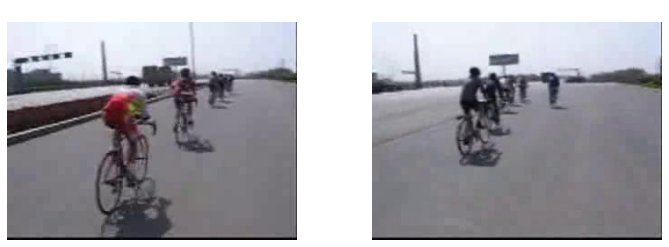

In [ ]:
output_2img(first_frame_im,second_frame_im)

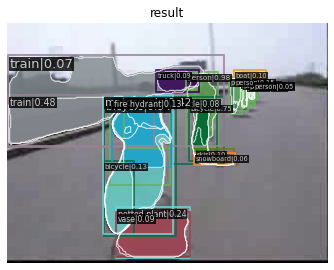

In [ ]:
show_result_pyplot(model,first_frame,result_1,score_thr=0)

In [ ]:
show_result_pyplot(model,first_frame,result_1,score_thr=0.5,out_file='/content/drive/MyDrive/thr_05_image.png')

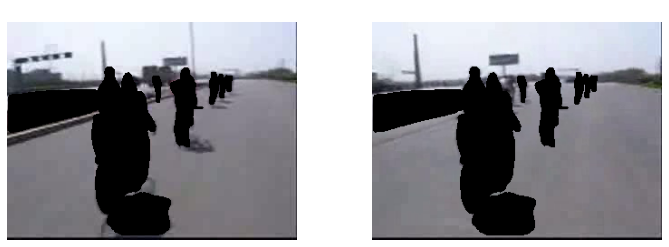

In [ ]:
masking_first_frame_12,masking_second_frame_12 = double_masking_img(first_frame_im,second_frame_im,mask_1,mask_2)
output_2img(masking_first_frame_12,masking_second_frame_12)

In [ ]:
mask_ = np.multiply(mask_2,mask_1)

In [ ]:
# cv2.imwrite("/content/drive/MyDrive/mask_sample1.png", mask_1)
# cv2.imwrite("/content/drive/MyDrive/mask_sample2.png", mask_2)
cv2.imwrite("/content/drive/MyDrive/masking_image_sample1_bike.png", masking_first_frame_12)
cv2.imwrite("/content/drive/MyDrive/masking_image_sample2_bike.png", masking_second_frame_12)

True

In [ ]:
portion_calculate_PSNR(masking_first_frame_12,masking_second_frame_12)#マスクの部分を除外してpsnrを計算

18.11869346924777

In [ ]:
SSIM_com(first_frame_im,second_frame_im,mask_)#maskありssim計算

(0.6650525315923466, 1572)

In [ ]:
SSIM_com(first_frame_im,second_frame_im)#maskなしssim計算

(0.5722097564897809, 1827)